In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import Model, Input


In [2]:
# Data dir
meta_path = 'Dataset/last/XWines_Test_100_wines.csv'
img_dir = 'Dataset/last/Xwines_Test_100_labels/'
# Load metadata
df = pd.read_csv(meta_path)
# Add image paths
df['image_path'] = df['WineID'].astype(str) + '.jpeg'
df['image_path'] = df['image_path'].apply(lambda x: os.path.join(img_dir, x))
# Show available label types
print(df['Type'].unique())

['Red' 'White' 'Dessert/Port' 'Sparkling' 'Rosé' 'Dessert']


In [3]:
print(df.head())

   WineID                          WineName          Type         Elaborate  \
0  100062                     Origem Merlot           Red     Varietal/100%   
1  100191                Reserva Chardonnay         White     Varietal/100%   
2  101847  Dona Antonia Porto Reserva Tawny  Dessert/Port  Assemblage/Blend   
3  102055                    Fine Ruby Port  Dessert/Port  Assemblage/Blend   
4  102079                         Maré Alta         White  Assemblage/Blend   

                                              Grapes  \
0                                         ['Merlot']   
1                                     ['Chardonnay']   
2  ['Touriga Nacional', 'Touriga Franca', 'Tinta ...   
3  ['Tinta Amarela', 'Tinta Barroca', 'Touriga Fr...   
4                ['Loureiro', 'Alvarinho', 'Arinto']   

                                           Harmonize   ABV               Body  \
0  ['Beef', 'Lamb', 'Veal', 'Grilled', 'Pizza', '...  13.0        Full-bodied   
1  ['Rich Fish', 'Seafood'

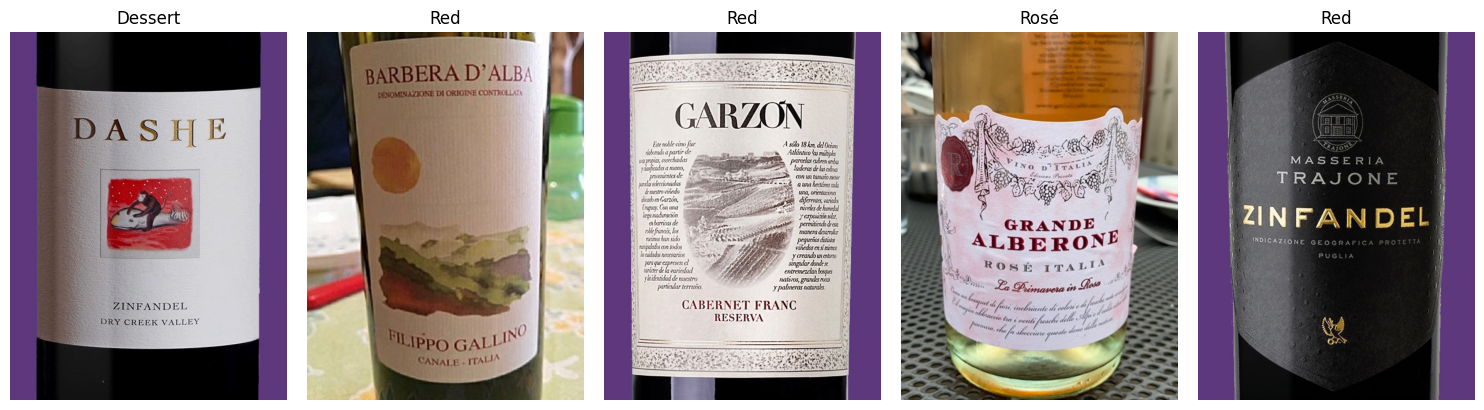

In [4]:
# Visualizing 5 random sample wine labels with their type
sample_df = df.sample(5, random_state=42)
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img = mpimg.imread(row['image_path'])
    ax.imshow(img)
    ax.set_title(row['Type'])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# Prepare image data for modelling
# 1. Filter only rows with existing image paths
df = df[df['image_path'].apply(os.path.exists)]
# 2. Encode the 'Type' column as numerical labels
label_encoder = LabelEncoder()
df['type_label'] = label_encoder.fit_transform(df['Type'])
# 3. Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=7, stratify=df['type_label'])
# 4. Set image params
img_height, img_width = 224, 224
batch_size = 32


In [26]:
# Data augmentation and preprocessing for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=60,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   shear_range=0.4,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   brightness_range=(0.7, 1.3))
# Data augmentation for validation set (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='image_path',
    y_col='Type',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=None,
    x_col='image_path',
    y_col='Type',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 80 validated image filenames belonging to 6 classes.
Found 20 validated image filenames belonging to 6 classes.


In [27]:
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['type_label']
)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Training samples: 80, Validation samples: 20


In [28]:
num_classes = df['Type'].nunique()

model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     5,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,977,510 (22.80 MB)

 Trainable params: 5,977,510 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_baseline_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

epochs = 70

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=epochs,
    callbacks=[checkpoint, early_stopping]
)
model.load_weights('best_baseline_model.h5')
loss, accuracy = model.evaluate(val_generator)
print(f"Best Model Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Epoch 1/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6917 - loss: 0.9605
Epoch 1: val_loss improved from inf to 1.05233, saving model to best_baseline_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - accuracy: 0.6938 - loss: 0.9651 - val_accuracy: 0.6000 - val_loss: 1.0523
Epoch 2/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7090 - loss: 0.9681
Epoch 2: val_loss improved from 1.05233 to 1.01024, saving model to best_baseline_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.6911 - loss: 0.9888 - val_accuracy: 0.6500 - val_loss: 1.0102
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7014 - loss: 1.0291
Epoch 3: val_loss did not improve from 1.01024
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 488ms/step - accuracy: 0.6979 - loss: 1.0219 - val_accuracy: 0.6500 - val_loss: 1.0304
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6802 - loss: 0.9647
Epoch 4: val_loss did not improve from 1.01024
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.6727 - loss: 0.9793 - val_accuracy: 0.6500 - val_loss: 1.0377
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6799 - loss: 0.9893
Epoch 5: val_loss did not improve from 1.01024
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step - accuracy: 0.6786 - loss: 0.9920 - val_accuracy: 0.6500 - val_loss: 1.0308
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6132 - loss: 1.0452
Epoch 6: val_loss did not improve from 1.01024
3/3 ━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 612ms/step - accuracy: 0.6656 - loss: 0.9862 - val_accuracy: 0.6500 - val_loss: 0.9950
Epoch 9/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7240 - loss: 0.8468
Epoch 9: val_loss improved from 0.99499 to 0.96694, saving model to best_baseline_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 659ms/step - accuracy: 0.7148 - loss: 0.8455 - val_accuracy: 0.7000 - val_loss: 0.9669
Epoch 10/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6719 - loss: 1.0552
Epoch 10: val_loss did not improve from 0.96694
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - accuracy: 0.6758 - loss: 1.0465 - val_accuracy: 0.7000 - val_loss: 0.9939
Epoch 11/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6757 - loss: 1.0141
Epoch 11: val_loss did not improve from 0.96694
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step - accuracy: 0.6724 - loss: 1.0078 - val_accuracy: 0.7000 - val_loss: 1.1395
Epoch 12/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6094 - loss: 1.0227
Epoch 12: val_loss did not improve from 0.96694
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - accuracy: 0.6133 - loss: 1.0149 - val_accuracy: 0.6500 - val_loss: 1.2376
Epoch 13/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6792 - loss: 0.7993
Epoch 13: val_loss did not improve from 0.96694
3/3 ━━━━

In [54]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7000 - loss: 0.9669
Validation Loss: 0.9669, Validation Accuracy: 0.7000


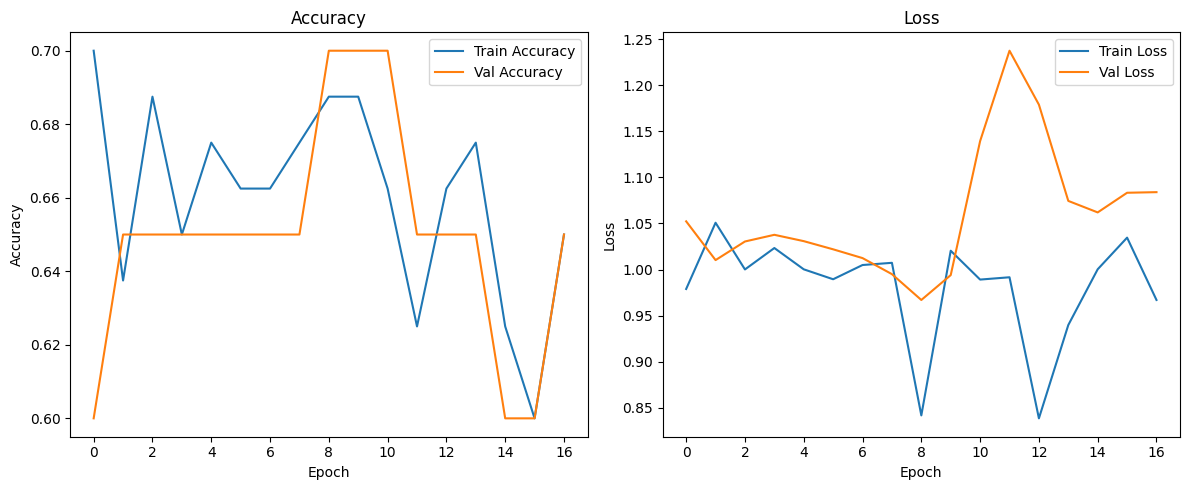

In [55]:
# Plot training & validation accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


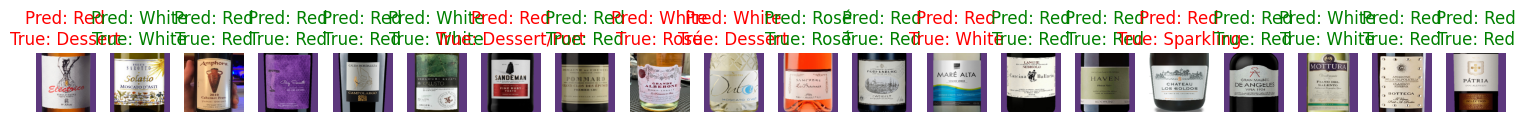

In [56]:
# Predict and visualize results on test images

# Get a batch of test images and true labels
test_images, test_labels = next(val_generator)
# Predict the classes for the test images
pred_probs = model.predict(test_images)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(test_labels, axis=1)
class_names = list(val_generator.class_indices.keys())

# Visualize the first 5 test images with their predicted and true labels
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(1, 20, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[true_classes[i]]}",
              color='green' if pred_classes[i] == true_classes[i] else 'red')
plt.tight_layout()
plt.show()



In [ ]:
# Transfer learning with MobileNetV2
                        
inputs = Input(shape=(img_height, img_width, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
# base_model.trainable = True 
for layer in base_model.layers[:-30]:
    layer.trainable = True  
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

transfer_model = Model(inputs, outputs)
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

/var/folders/rh/khbxvcws7rzgl9vsh4k_t7t40000gn/T/ipykernel_4569/1281940425.py:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)


In [79]:
# Train the transfer learning model
"""transfer_history = transfer_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=epochs,
    callbacks=[checkpoint, early_stopping]
)"""

v2_early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
v2_checkpoint = ModelCheckpoint('best_v2_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
1
fine_tune_epochs = 70
fine_tune_history = transfer_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=fine_tune_epochs,
    callbacks=[v2_checkpoint, v2_early_stopping]
)
transfer_model.load_weights('best_v2_model.h5')
loss, accuracy = transfer_model.evaluate(val_generator)
print(f"Best Model Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Epoch 1/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2062 - loss: 2.3664
Epoch 1: val_loss improved from inf to 2.10939, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.2078 - loss: 2.3605 - val_accuracy: 0.3000 - val_loss: 2.1094
Epoch 2/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2885 - loss: 2.1292
Epoch 2: val_loss improved from 2.10939 to 2.10818, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2727 - loss: 2.1509 - val_accuracy: 0.3000 - val_loss: 2.1082
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2500 - loss: 2.0949   
Epoch 3: val_loss improved from 2.10818 to 2.10700, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2500 - loss: 2.0921 - val_accuracy: 0.3000 - val_loss: 2.1070
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1681 - loss: 2.1684  
Epoch 4: val_loss improved from 2.10700 to 2.10607, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1635 - loss: 2.1693 - val_accuracy: 0.3000 - val_loss: 2.1061
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2375 - loss: 2.1422
Epoch 5: val_loss improved from 2.10607 to 2.10516, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2313 - loss: 2.1450 - val_accuracy: 0.3000 - val_loss: 2.1052
Epoch 6/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1500 - loss: 2.2862   
Epoch 6: val_loss improved from 2.10516 to 2.10405, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1469 - loss: 2.2900 - val_accuracy: 0.3000 - val_loss: 2.1041
Epoch 7/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1562 - loss: 2.3153   
Epoch 7: val_loss improved from 2.10405 to 2.10289, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1641 - loss: 2.2956 - val_accuracy: 0.3000 - val_loss: 2.1029
Epoch 8/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2528 - loss: 2.1535  
Epoch 8: val_loss improved from 2.10289 to 2.10203, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2490 - loss: 2.1613 - val_accuracy: 0.3000 - val_loss: 2.1020
Epoch 9/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1472 - loss: 2.4719  
Epoch 9: val_loss improved from 2.10203 to 2.10114, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1479 - loss: 2.4356 - val_accuracy: 0.3000 - val_loss: 2.1011
Epoch 10/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2417 - loss: 2.1021
Epoch 10: val_loss improved from 2.10114 to 2.10039, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2375 - loss: 2.1071 - val_accuracy: 0.3000 - val_loss: 2.1004
Epoch 11/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1292 - loss: 2.5011
Epoch 11: val_loss improved from 2.10039 to 2.09941, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1312 - loss: 2.4850 - val_accuracy: 0.3000 - val_loss: 2.0994
Epoch 12/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2465 - loss: 2.1108   
Epoch 12: val_loss improved from 2.09941 to 2.09876, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2474 - loss: 2.1110 - val_accuracy: 0.3000 - val_loss: 2.0988
Epoch 13/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1948 - loss: 2.2427
Epoch 13: val_loss improved from 2.09876 to 2.09806, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2023 - loss: 2.2237 - val_accuracy: 0.3000 - val_loss: 2.0981
Epoch 14/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2313 - loss: 2.2194
Epoch 14: val_loss improved from 2.09806 to 2.09702, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2297 - loss: 2.2209 - val_accuracy: 0.3000 - val_loss: 2.0970
Epoch 15/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2111 - loss: 2.1389  
Epoch 15: val_loss improved from 2.09702 to 2.09581, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2177 - loss: 2.1249 - val_accuracy: 0.3000 - val_loss: 2.0958
Epoch 16/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2604 - loss: 2.1147   
Epoch 16: val_loss improved from 2.09581 to 2.09476, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2578 - loss: 2.1470 - val_accuracy: 0.3000 - val_loss: 2.0948
Epoch 17/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2094 - loss: 2.0237
Epoch 17: val_loss improved from 2.09476 to 2.09347, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2164 - loss: 2.0349 - val_accuracy: 0.3000 - val_loss: 2.0935
Epoch 18/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1375 - loss: 2.1581   
Epoch 18: val_loss improved from 2.09347 to 2.09228, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1437 - loss: 2.1752 - val_accuracy: 0.3000 - val_loss: 2.0923
Epoch 19/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2240 - loss: 2.1309
Epoch 19: val_loss improved from 2.09228 to 2.09107, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2305 - loss: 2.1282 - val_accuracy: 0.3000 - val_loss: 2.0911
Epoch 20/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2396 - loss: 2.1286
Epoch 20: val_loss improved from 2.09107 to 2.08987, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2422 - loss: 2.1256 - val_accuracy: 0.3000 - val_loss: 2.0899
Epoch 21/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2681 - loss: 2.0921   
Epoch 21: val_loss improved from 2.08987 to 2.08839, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2667 - loss: 2.0931 - val_accuracy: 0.3000 - val_loss: 2.0884
Epoch 22/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2243 - loss: 2.0763   
Epoch 22: val_loss improved from 2.08839 to 2.08706, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2245 - loss: 2.0757 - val_accuracy: 0.3000 - val_loss: 2.0871
Epoch 23/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2667 - loss: 2.2173  
Epoch 23: val_loss improved from 2.08706 to 2.08627, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2750 - loss: 2.2110 - val_accuracy: 0.3000 - val_loss: 2.0863
Epoch 24/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2552 - loss: 2.1911
Epoch 24: val_loss improved from 2.08627 to 2.08515, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2539 - loss: 2.1926 - val_accuracy: 0.3000 - val_loss: 2.0852
Epoch 25/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2347 - loss: 1.9272  
Epoch 25: val_loss improved from 2.08515 to 2.08397, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2323 - loss: 1.9755 - val_accuracy: 0.3000 - val_loss: 2.0840
Epoch 26/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1729 - loss: 2.3378
Epoch 26: val_loss improved from 2.08397 to 2.08302, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1734 - loss: 2.3304 - val_accuracy: 0.3000 - val_loss: 2.0830
Epoch 27/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2281 - loss: 2.1024
Epoch 27: val_loss improved from 2.08302 to 2.08182, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2211 - loss: 2.1154 - val_accuracy: 0.3000 - val_loss: 2.0818
Epoch 28/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2049 - loss: 2.1934   
Epoch 28: val_loss improved from 2.08182 to 2.08105, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2005 - loss: 2.1924 - val_accuracy: 0.3000 - val_loss: 2.0811
Epoch 29/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1677 - loss: 2.1955
Epoch 29: val_loss improved from 2.08105 to 2.08030, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1695 - loss: 2.1960 - val_accuracy: 0.3000 - val_loss: 2.0803
Epoch 30/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2972 - loss: 2.0810  
Epoch 30: val_loss improved from 2.08030 to 2.07934, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2792 - loss: 2.1249 - val_accuracy: 0.3000 - val_loss: 2.0793
Epoch 31/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1375 - loss: 2.1744
Epoch 31: val_loss improved from 2.07934 to 2.07839, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1437 - loss: 2.1722 - val_accuracy: 0.3000 - val_loss: 2.0784
Epoch 32/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1444 - loss: 2.3217   
Epoch 32: val_loss improved from 2.07839 to 2.07737, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1490 - loss: 2.2812 - val_accuracy: 0.3000 - val_loss: 2.0774
Epoch 33/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1375 - loss: 2.2125
Epoch 33: val_loss improved from 2.07737 to 2.07680, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.1437 - loss: 2.2140 - val_accuracy: 0.3000 - val_loss: 2.0768
Epoch 34/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2556 - loss: 2.2001   
Epoch 34: val_loss improved from 2.07680 to 2.07603, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2479 - loss: 2.1959 - val_accuracy: 0.3000 - val_loss: 2.0760
Epoch 35/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2823 - loss: 2.1309
Epoch 35: val_loss improved from 2.07603 to 2.07516, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2711 - loss: 2.1589 - val_accuracy: 0.3000 - val_loss: 2.0752
Epoch 36/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2111 - loss: 2.0613
Epoch 36: val_loss improved from 2.07516 to 2.07399, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2177 - loss: 2.0755 - val_accuracy: 0.3000 - val_loss: 2.0740
Epoch 37/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2736 - loss: 2.0008
Epoch 37: val_loss improved from 2.07399 to 2.07277, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2646 - loss: 2.0129 - val_accuracy: 0.3000 - val_loss: 2.0728
Epoch 38/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2917 - loss: 1.9469
Epoch 38: val_loss improved from 2.07277 to 2.07180, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2969 - loss: 1.9399 - val_accuracy: 0.3000 - val_loss: 2.0718
Epoch 39/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2799 - loss: 1.8997   
Epoch 39: val_loss improved from 2.07180 to 2.07086, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2818 - loss: 1.9095 - val_accuracy: 0.3000 - val_loss: 2.0709
Epoch 40/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3583 - loss: 1.9303
Epoch 40: val_loss improved from 2.07086 to 2.07008, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3500 - loss: 1.9343 - val_accuracy: 0.3000 - val_loss: 2.0701
Epoch 41/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2021 - loss: 2.1201   
Epoch 41: val_loss improved from 2.07008 to 2.06940, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2016 - loss: 2.1346 - val_accuracy: 0.3000 - val_loss: 2.0694
Epoch 42/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2639 - loss: 2.2473  
Epoch 42: val_loss improved from 2.06940 to 2.06863, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2604 - loss: 2.2185 - val_accuracy: 0.3000 - val_loss: 2.0686
Epoch 43/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1444 - loss: 2.2656   
Epoch 43: val_loss improved from 2.06863 to 2.06823, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1490 - loss: 2.2479 - val_accuracy: 0.3000 - val_loss: 2.0682
Epoch 44/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2806 - loss: 2.0761
Epoch 44: val_loss improved from 2.06823 to 2.06760, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2542 - loss: 2.1235 - val_accuracy: 0.3000 - val_loss: 2.0676
Epoch 45/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1667 - loss: 2.1855  
Epoch 45: val_loss improved from 2.06760 to 2.06721, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.1719 - loss: 2.1742 - val_accuracy: 0.3000 - val_loss: 2.0672
Epoch 46/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1694 - loss: 2.3510   
Epoch 46: val_loss improved from 2.06721 to 2.06685, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1708 - loss: 2.3255 - val_accuracy: 0.3000 - val_loss: 2.0669
Epoch 47/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2993 - loss: 2.1158   
Epoch 47: val_loss improved from 2.06685 to 2.06652, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2901 - loss: 2.1280 - val_accuracy: 0.3000 - val_loss: 2.0665
Epoch 48/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2722 - loss: 1.9138  
Epoch 48: val_loss improved from 2.06652 to 2.06608, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2729 - loss: 1.9358 - val_accuracy: 0.3000 - val_loss: 2.0661
Epoch 49/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1667 - loss: 2.2610  
Epoch 49: val_loss improved from 2.06608 to 2.06573, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.1719 - loss: 2.2528 - val_accuracy: 0.3000 - val_loss: 2.0657
Epoch 50/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3201 - loss: 2.0551   
Epoch 50: val_loss improved from 2.06573 to 2.06511, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3214 - loss: 2.0544 - val_accuracy: 0.3000 - val_loss: 2.0651
Epoch 51/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2194 - loss: 2.2701   
Epoch 51: val_loss improved from 2.06511 to 2.06454, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2302 - loss: 2.2400 - val_accuracy: 0.3000 - val_loss: 2.0645
Epoch 52/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1677 - loss: 2.1008
Epoch 52: val_loss improved from 2.06454 to 2.06351, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1695 - loss: 2.0921 - val_accuracy: 0.3000 - val_loss: 2.0635
Epoch 53/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1569 - loss: 2.1167  
Epoch 53: val_loss improved from 2.06351 to 2.06232, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1677 - loss: 2.1046 - val_accuracy: 0.3000 - val_loss: 2.0623
Epoch 54/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2444 - loss: 2.0847   
Epoch 54: val_loss improved from 2.06232 to 2.06140, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2365 - loss: 2.1006 - val_accuracy: 0.3000 - val_loss: 2.0614
Epoch 55/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2729 - loss: 2.0543
Epoch 55: val_loss improved from 2.06140 to 2.06027, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.2766 - loss: 2.0378 - val_accuracy: 0.3000 - val_loss: 2.0603
Epoch 56/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2868 - loss: 2.1520   
Epoch 56: val_loss improved from 2.06027 to 2.05925, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2870 - loss: 2.1410 - val_accuracy: 0.3000 - val_loss: 2.0592
Epoch 57/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2740 - loss: 1.9572
Epoch 57: val_loss improved from 2.05925 to 2.05836, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2742 - loss: 1.9801 - val_accuracy: 0.3000 - val_loss: 2.0584
Epoch 58/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3326 - loss: 1.9564    
Epoch 58: val_loss improved from 2.05836 to 2.05751, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 563s 4s/step - accuracy: 0.3401 - loss: 1.9573 - val_accuracy: 0.3000 - val_loss: 2.0575
Epoch 59/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3014 - loss: 2.0232
Epoch 59: val_loss improved from 2.05751 to 2.05672, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3010 - loss: 2.0437 - val_accuracy: 0.3000 - val_loss: 2.0567
Epoch 60/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3118 - loss: 2.0814
Epoch 60: val_loss improved from 2.05672 to 2.05564, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2932 - loss: 2.1206 - val_accuracy: 0.3000 - val_loss: 2.0556
Epoch 61/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2562 - loss: 2.1969
Epoch 61: val_loss improved from 2.05564 to 2.05436, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.2672 - loss: 2.1730 - val_accuracy: 0.3000 - val_loss: 2.0544
Epoch 62/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3715 - loss: 1.8364
Epoch 62: val_loss improved from 2.05436 to 2.05350, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.3568 - loss: 1.8710 - val_accuracy: 0.3000 - val_loss: 2.0535
Epoch 63/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2181 - loss: 2.0177   
Epoch 63: val_loss improved from 2.05350 to 2.05247, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2229 - loss: 2.0124 - val_accuracy: 0.3000 - val_loss: 2.0525
Epoch 64/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2604 - loss: 1.9562
Epoch 64: val_loss improved from 2.05247 to 2.05144, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.2578 - loss: 1.9698 - val_accuracy: 0.3000 - val_loss: 2.0514
Epoch 65/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2979 - loss: 2.0472
Epoch 65: val_loss improved from 2.05144 to 2.05040, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.2984 - loss: 2.0317 - val_accuracy: 0.3000 - val_loss: 2.0504
Epoch 66/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2333 - loss: 2.1920
Epoch 66: val_loss improved from 2.05040 to 2.04939, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.2250 - loss: 2.2092 - val_accuracy: 0.3000 - val_loss: 2.0494
Epoch 67/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2594 - loss: 2.0762
Epoch 67: val_loss improved from 2.04939 to 2.04851, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.2758 - loss: 2.0345 - val_accuracy: 0.3000 - val_loss: 2.0485
Epoch 68/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2021 - loss: 2.1572
Epoch 68: val_loss improved from 2.04851 to 2.04772, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2016 - loss: 2.1550 - val_accuracy: 0.3000 - val_loss: 2.0477
Epoch 69/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2094 - loss: 2.1255
Epoch 69: val_loss improved from 2.04772 to 2.04653, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2164 - loss: 2.0979 - val_accuracy: 0.3000 - val_loss: 2.0465
Epoch 70/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2385 - loss: 2.0911
Epoch 70: val_loss improved from 2.04653 to 2.04539, saving model to best_v2_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2445 - loss: 2.0736 - val_accuracy: 0.3000 - val_loss: 2.0454
Restoring model weights from the end of the best epoch: 70.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.3000 - loss: 2.0454
Best Model Validation Loss: 2.0454, Validation Accuracy: 0.3000


In [1]:
# Evaluate the transfer learning model
loss, accuracy = transfer_model.evaluate(val_generator)
print(f"Transfer Learning Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

NameError: name 'transfer_model' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.2000 - loss: 2.0575
Transfer Learning Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}


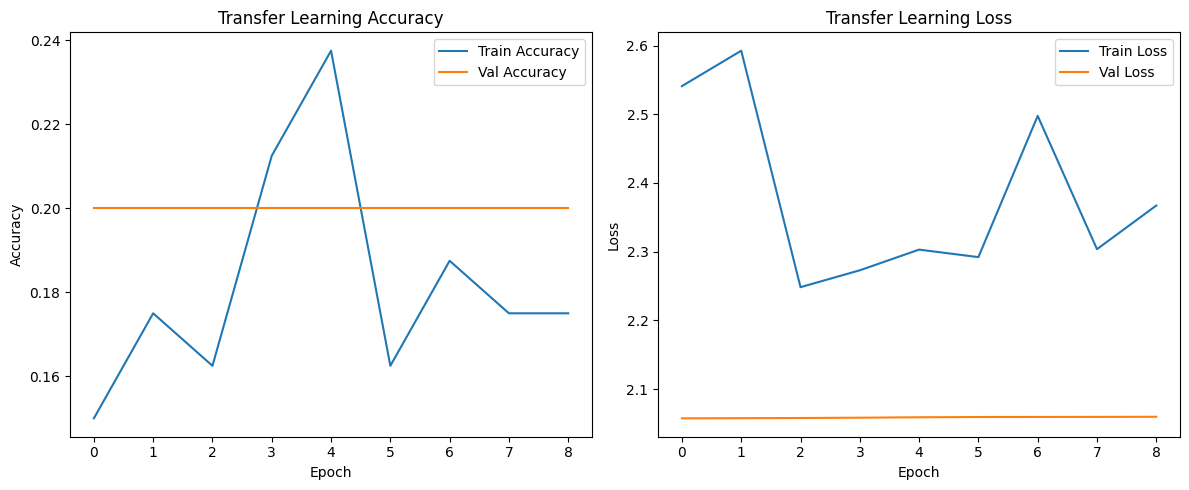

In [74]:
# Evaluate and visualize transfer learning model results
# Evaluate on validation data
loss, accuracy = transfer_model.evaluate(val_generator)
print("Transfer Learning Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
# Plot training & validation accuracy and loss curves for transfer learning
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Transfer Learning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Transfer Learning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


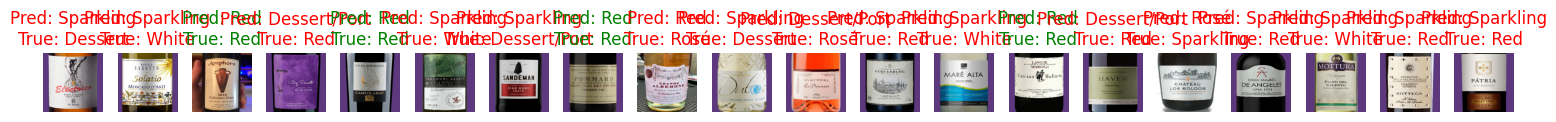

In [75]:
test_images, test_labels = next(val_generator)
# Predict the classes for the test images using the transfer learning model
pred_probs_transfer = transfer_model.predict(test_images)
pred_classes_transfer = np.argmax(pred_probs_transfer, axis=1)
true_classes_transfer = np.argmax(test_labels, axis=1)
# Visualize the first 5 test images with their predicted and true labels using transfer learning
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(1, 20, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(f"Pred: {class_names[pred_classes_transfer[i]]}\nTrue: {class_names[true_classes_transfer[i]]}",
              color='green' if pred_classes_transfer[i] == true_classes_transfer[i] else 'red')
plt.tight_layout()
plt.show()

In [202]:
v3_inputs = Input(shape=(img_height, img_width, 3))
base_model_v3 = MobileNetV3Small(weights='imagenet', include_top=False, input_tensor=v3_inputs)
base_model_v3.trainable = True  # Freeze the base model
for layer in base_model_v3.layers[:-30]:
    layer.trainable = False  # Freeze all layers except the last 30
v3_x = layers.GlobalAveragePooling2D()(base_model_v3.output)
v3_x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(v3_x)
v3_x = layers.Dropout(0.5)(v3_x)
v3_outputs = layers.Dense(num_classes, activation='softmax')(v3_x)
v3_transfer_model = Model(v3_inputs, v3_outputs)
v3_transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [205]:
v3_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
v3_checkpoint = ModelCheckpoint('best_v3_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

fine_tune_epochs = 70
fine_tune_history = v3_transfer_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=fine_tune_epochs,
    callbacks=[v3_checkpoint, v3_early_stopping]
)

Epoch 1/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.1125 - loss: 2.2730
Epoch 1: val_loss improved from inf to 2.06846, saving model to best_v3_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step - accuracy: 0.1219 - loss: 2.2604 - val_accuracy: 0.0500 - val_loss: 2.0685
Epoch 2/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.1979 - loss: 2.2246
Epoch 2: val_loss did not improve from 2.06846
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - accuracy: 0.1953 - loss: 2.2214 - val_accuracy: 0.0500 - val_loss: 2.0692
Epoch 3/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.2049 - loss: 2.3753
Epoch 3: val_loss did not improve from 2.06846
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step - accuracy: 0.2005 - loss: 2.3600 - val_accuracy: 0.0500 - val_loss: 2.0700
Epoch 4/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.0594 - loss: 2.4277
Epoch 4: val_loss did not improve from 2.06846
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.0695 - loss: 2.4067 - val_accuracy: 0.0500 - val_loss: 2.0708
Epoch 5/70
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.1778 - loss: 2.2605
Epoch 5: val_loss did not improve from 2.06846
3/3 ━━━━━━━━━━━━

In [ ]:
# Evaluate and visualize transfer learning model results
# Evaluate on validation data
loss, accuracy = transfer_model.evaluate(val_generator)
print("Transfer Learning Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
# Plot training & validation accuracy and loss curves for transfer learning
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Transfer Learning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Transfer Learning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()